In [1]:
import msprime
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG

plt.rcParams["figure.figsize"] = (10,7)

(sec_demography)=

# Demographic models

By default, msprime assumes a single randomly mating population of a fixed
size for {ref}`ancestry simulations <sec_ancestry>`, which is unrealistic
for most purposes. To enable more realistic and complex simulations,
msprime models population structure
by defining a set of discrete {ref}`sec_demography_populations`,
with {ref}`sec_demography_migration` between these populations occurring
at different rates. Populations and their parameters can
change over time, via {ref}`demographic events<sec_demography_events>`.
Please see the {ref}`sec_demography_definitions`
section for mathematical details.

The information required to define a demographic model is encapsulated
by the {class}`.Demography` object. To run
{ref}`ancestry simulations <sec_ancestry>` for a given demography
we use the `demography` parameter to {func}`.sim_ancestry` and define
what populations our {ref}`samples <sec_ancestry_samples>` are drawn from.
For example, here we create a three-population model in which
populations ``A`` and ``B`` split from ``C`` 1000 generations ago.
We then run an ancestry simulation based on this demography;
here we draw one diploid sample each from ``A`` and ``B`` at time zero:

In [2]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=10_000)
demography.add_population(name="B", initial_size=5_000)
demography.add_population(name="C", initial_size=1_000)
demography.add_population_split(time=1000, derived=["A", "B"], ancestral="C")
ts = msprime.sim_ancestry(samples={"A": 1, "B": 1}, demography=demography, random_seed=12)
ts

Please see the {ref}`sec_demography_examples` section for
more detailed examples of models from the literature.

---

## Quick reference

{class}`.Demography`
: Description of a demographic model

**Building models**

{meth}`.Demography.add_population`
: Add a population to the model

{meth}`.Demography.set_symmetric_migration_rate`
: Sets the symmetric migration rates among a set of populations

{meth}`.Demography.set_migration_rate`
: Sets the migration rate from one population to another

{meth}`.Demography.add_population_parameters_change`
: Change population size and growth rate values at some time

{meth}`.Demography.add_migration_rate_change`
: Change the migration rate from one population to another at some time

{meth}`.Demography.add_symmetric_migration_rate_change`
: Change the migration rate among a set of populations at some time

{meth}`.Demography.add_population_split`
: One or more derived populations split from an ancestral population at a given time

{meth}`.Demography.add_admixture`
: A derived population where the given fractions of the individuals are
  migrants from the corresponding ancestral populations.


**Predefined theoretical models**

{meth}`.Demography.isolated_model`
: A model of isolated populations

{meth}`.Demography.island_model`
: An interconnected web of populations

{meth}`.Demography.stepping_stone_model`
: Simple spatial model

**Constructing models from existing definitions**

{meth}`.Demography.from_species_tree`
: Parse a newick species tree

{meth}`.Demography.from_starbeast`
: Parse StarBeast output

{meth}`.Demography.from_old_style`
: Demography from msprime legacy 0.x inputs

**Debugging**

{meth}`.Demography.debug`
: Get a Debugger for a demography

{class}`.DemographyDebugger`
: Debugger for demographic models

**Numerical methods**

{meth}`.DemographyDebugger.coalescence_rate_trajectory`
: Compute mean coalescence rate and fraction of uncoalesced lineages

{meth}`.DemographyDebugger.mean_coalescence_time`
: Compute the mean time until coalescence

{meth}`.DemographyDebugger.lineage_probabilities`
: Probability of the location of lineages over time

---

## Model

In this section we define the model used to describe demography
in msprime, as encapsulated by a {class}`.Demography` object.

(sec_demography_direction_of_time)=

### Direction of time

Msprime simulates retrospective population models like the coalescent
in which we begin with a sample of lineages at the present time
and then simulate the historical events that affect these lineages.
The process moves **backwards in time**, and time is measured in
units of **generations ago**. Everything in msprime is considered from
this backwards in time perspective of the simulation.
So here, and throughout the documentation,
when we say something happens "before" or "after" a particular event
this is in terms of the simulation itself, and therefore usually
the **opposite** of what you would mean if thinking about things
forwards in time.

This is initially very confusing, but getting used to thinking "backwards in
time" is essential for coalescent modelling and working with ancestral
histories in general, so it's worth the effort of getting used to it. For
example, understanding how different patterns of lineages moving from one
population to another backwards in time corresponds to
{ref}`population splits<sec_demography_events_population_split>` and
{ref}`admixture<sec_demography_events_admixture>` events is a
great way to deepen your understanding of the coalescent in general.

Mostly it doesn't matter, and it's just a point of clarification
for reading this documentation and understanding why the models
we define are usually expressed backwards in time. However,
it is essential to be remember that ``source`` and ``dest``
populations are from the perspective of the coalescent
when describing {ref}`migration<sec_demography_migration>`,
which we try to flag in this documentation where it's important.

(sec_demography_definitions)=

### Definitions

Formally, population structure in msprime is modelled by specifying a fixed
number of subpopulations {math}`d`.
Each population has an initial absolute population size {math}`s`
and a per generation exponential growth rate {math}`\alpha`. The size of a
given population at time {math}`t` in the past (measured in generations) is
therefore given by {math}`s e^{-\alpha t}`. Demographic events that occur in
the history of the simulated population alter some aspect of this population
configuration at a particular time in the past.

Continuous migration between populations is modelled by a
{math}`d \times d` matrix {math}`M` of per-generation migration rates.
The {math}`(j,k)^{th}` entry
of {math}`M` is the expected number of migrants moving from population
{math}`k` to population {math}`j` per generation, divided by the size of
population {math}`j`. In terms of the coalescent process, {math}`M_{j,k}`
gives the rate at which an ancestral lineage moves from population
{math}`j` to population {math}`k`, as one follows it back through time. In
continuous-time models, when {math}`M_{j,k}` is close to zero, this rate is
approximately equivalent to the fraction of population {math}`j` that is
replaced each generation by migrants from population {math}`k`. In
discrete-time models, the equivalence is exact and each row of {math}`M`
has the constraint {math}`\sum_{k \neq j} M_{j,k} \leq 1`. This differs
from the migration matrix one usually uses in population demography: if
{math}`m_{k,j}` is the proportion of individuals (in the usual sense; not
lineages) in population {math}`k` that move to population {math}`j` per
generation, then translating this proportion of population {math}`k` to a
proportion of population {math}`j`, we have
{math}`M_{j,k} = m_{k,j} \times N_k / N_j`.

The details of population structure in msprime closely follow the model
used in the classical
[ms](https://academic.oup.com/bioinformatics/article/18/2/337/225783)
program.

---

(sec_demography_populations)=

### Populations

A {class}`.Demography` contains a list of {class}`.Population` objects.
A population represents some randomly mating set of individuals that
optionally exchange migrants with other populations at some rate.

:::{note}
Msprime version 0.x performed poorly when there were large numbers of
populations, even if most of those populations had no lineages present
for much of the simulation.
Version 1 has a much better support for large numbers of populations,
and there is now no performance cost for having inactive populations.
:::

Populations essentially have two purposes:

1. To define the state of the population at the start of the simulation (i.e.,
    the {ref}`sec_demography_populations_initial_size` and
    the {ref}`sec_demography_populations_growth_rate`)
2. To define {ref}`sec_demography_populations_metadata` which is
    associated with the corresponding {class}`tskit.Population` objects
    in simulated tree sequences.

Populations additionally have a "state" which determines whether lineages
can be present within them or not at a given time, as described in
the {ref}`sec_demography_populations_life_cycle` section.

(sec_demography_populations_identifiers)=

#### Identifying populations

When used as part of the {class}`.Demography`, each population has an integer
ID (its zero-based index in the `populations` list) and a ``name`` attribute.
By default, msprime assigns the name `pop_j` to the population at index
`j` in a demographic model. These default names can be overridden, and
users should give populations more descriptive names when building complex models.

:::{Attention}
Population names must be unique within a single {class}`.Demography` and be valid
[Python identifiers](https://docs.python.org/3/reference/lexical_analysis.html#identifiers).
For example, this means that names like "my_pop_1" is valid, but "my-pop-1" and "my pop 1"
are not.
:::

When defining empirical models (such as those in the {ref}`sec_demography_examples`
section) names should be chosen for clarity.
We also encourage the use
of {ref}`population split<sec_demography_events_population_split>`
events to explicitly name and describe the different phases of a demographic
history rather than use anonymous population size changes (as encouraged
by the {ref}`legacy 0.x API<sec_legacy_0x>`). This makes it easier
to interpret the resulting tree sequence files (since detailed metadata
about the populations in which coalescences occurred is maintained)
and makes it easier to avoid
[modelling errors](http://dx.doi.org/10.1016/j.ajhg.2020.08.017).

(sec_demography_populations_initial_size)=

#### Initial size

The `initial_size` of a population is its size at the start of a simulation
(looking {ref}`backwards in time<sec_demography_direction_of_time>`).
If the population's
{ref}`sec_demography_populations_growth_rate` is zero, then
the population will have the same size for all time (unless there are
some {ref}`sec_demography_events` that change these parameters).

:::{note}
The ``initial_size`` of a population refers to its size at time zero,
and is **not** affected by the simulation {ref}`start_time<sec_ancestry_start_time>`.
:::

When using methods like {meth}`.Demography.island_model` to describe
simple multipopulation models, the ``initial_size`` parameter takes
a **list** of size values which defines both the number of
populations and their sizes. For example, here we define two isolated
populations (i.e., which have no migration) with sizes 100 and 200:

In [3]:
demography = msprime.Demography.isolated_model([100, 200])
demography

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,pop_0,,100.0,0,0,{}
1,pop_1,,200.0,0,0,{}


When we have multiple populations that are the same size we can use
some Python tricks to avoid code duplication. For example, here
we create three populations with size 100:

In [4]:
demography = msprime.Demography.isolated_model([100] * 3)
demography

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,pop_0,,100.0,0,0,{}
1,pop_1,,100.0,0,0,{}
2,pop_2,,100.0,0,0,{}


:::{warning}
We use the {meth}`.Demography.isolated_model` function here as a
way to create example demographies. However, it's
important to note that simulations in which we sample from
multiple isolated populations will fail with an error because
the lineages in question can never coalesce. See
the {ref}`sec_ancestry_errors_infinite_waiting_time` section
for more details.
:::

(sec_demography_populations_growth_rate)=

#### Growth rate

Each population has an exponential growth rate so that the
size of a population with initial size {math}`s`
and growth rate {math}`\alpha` is {math}`s e^{-\alpha t}`
at time {math}`t` generations in the past (see the
{ref}`sec_demography_definitions` section for more details).

Growth rates for functions like {meth}`.Demography.island_model`
that construct a {class}`.Demography` are specified in a similar
way to {ref}`sec_demography_populations_initial_size`: we provide
a list of sizes equal to the number of populations. For
example, here we define 2 populations with different
population sizes and growth rates:

In [5]:
demography = msprime.Demography.isolated_model([100, 200], growth_rate=[0.01, 0.02])
demography

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,pop_0,,100.0,0.01,0,{}
1,pop_1,,200.0,0.02,0,{}


```{note}
The {class}`.DemographyDebugger` is a useful tool to help understand
how population sizes change over time. See the
{ref}`sec_demography_debugging_tools` section for details.
```

(sec_demography_populations_metadata)=

#### Metadata

In [tskit](https://tskit.dev/tskit) the {class}`Population<tskit.Population>` class
largely exists as a container for {ref}`tskit:sec_metadata`. Metadata is
important and useful: it lets us associate information about our simulated
populations with the output tree sequence, which we can then use
when we are analysing the data.

Msprime associates two pieces of mandatory metadata with every population:
their `name` and `description`. For example,

In [6]:
demography = msprime.Demography.stepping_stone_model([100, 100], migration_rate=0.01)
ts = msprime.sim_ancestry({0: 1, 1: 1}, demography=demography)
print([population.metadata for population in ts.populations()])

[{'description': '', 'name': 'pop_0'}, {'description': '', 'name': 'pop_1'}]


Here we have two populations in the output tree sequence, and the metadata
for each population is a dictionary containing the keys ``name`` and
``description``. These correspond to the same attributes on the msprime
{class}`.Population` class. We don't have to just use the defaults
for these values: we can set them to (more or less) anything we like.
For example,

In [7]:
demography = msprime.Demography.stepping_stone_model([100, 100], migration_rate=0.01)
demography[0].name = "awesome_pop"
demography[0].description = "This population is totally awesome"
demography[1].name = "more_awesome_pop"
demography[1].description = "This population is even more awesome"
ts = msprime.sim_ancestry({0: 1, 1: 1}, demography=demography)
for population in ts.populations():
    print(f"id={population.id}: {population.metadata}")

id=0: {'description': 'This population is totally awesome', 'name': 'awesome_pop'}
id=1: {'description': 'This population is even more awesome', 'name': 'more_awesome_pop'}


As well as the default ``name`` and ``description`` metadata keys
we can also associate additional metadata with population objects using
the ``extra_metadata`` attribute of the msprime {class}`.Population`
object. For example,

In [8]:
demography = msprime.Demography.stepping_stone_model([100, 100], migration_rate=0.01)
demography[0].name = "awesome_pop"
demography[0].extra_metadata = {"emoji": "👍"}
demography[1].name = "more_awesome_pop"
demography[1].extra_metadata = {"emoji": "🤘"}
ts = msprime.sim_ancestry({0: 1, 1: 1}, demography=demography)
for pop in ts.populations():
    print(pop.id, "\t", pop.metadata["emoji"], pop.metadata["name"])

0 	 👍 awesome_pop
1 	 🤘 more_awesome_pop


(sec_demography_populations_life_cycle)=

#### Life cycle

Each population has a ``state`` associated with it during the simulation,
which can be one of ``INACTIVE``, ``ACTIVE`` or ``PREVIOUSLY_ACTIVE``.
Populations can follow one of two state progressions:
```
INACTIVE → ACTIVE
```
and
```
ACTIVE → PREVIOUSLY_ACTIVE
```
All populations are ``ACTIVE`` by default at the start of the simulation
(looking {ref}`backwards in time<sec_demography_direction_of_time>`)
except if they are ``ancestral`` in a
{ref}`sec_demography_events_population_split`.
In this case populations are initially ``INACTIVE``, by default.
An ``ancestral`` population then transitions
from ``INACTIVE`` → ``ACTIVE`` when the corresponding
population split event occurs.

It is possible to override the default initial state of the population
that is ancestral in a population split event using the ``initially_active``
boolean flag in the {class}`.Population` class. This is to facilitate
"trunk population" models, as shown in
{ref}`this example<sec_demography_examples_trunk_population>`.

Populations transition from ``ACTIVE`` → ``PREVIOUSLY_ACTIVE`` when they
are ``derived`` in either population split or admixture events.

Any attempts to move lineages into a population that is not ``ACTIVE``
via sampling, continuous or pulse migration will result in an error
during the simulation.

(sec_demography_populations_default_sampling_time)=

#### Default sampling time

The ``default_sampling_time`` property of a {class}`.Population`
defines the default time at which samples will be drawn from a population
in {func}`.sim_ancestry`. See the
{ref}`sec_ancestry_samples` section for details on how this time
is used when running simulations, and how sampling time can also
be specified directly, overriding the population default.

The default sampling time can be specified directly using either
the {meth}`.Demography.add_population` method, or by setting the
``default_sampling_time`` attribute of the {class}`.Population`
later. The default value is 0, **unless** the population is
ancestral in a
{ref}`sec_demography_events_population_split` event added
using the {meth}`.Demography.add_population_split` method. In
this case the default sampling time is set to the
time of the event (i.e., when the population
{ref}`first<sec_demography_direction_of_time>`
becomes {ref}`active<sec_demography_populations_life_cycle>`),
unless the ``initially_active`` flag has been set.

(sec_demography_migration)=

### Migration

Migration is the process of lineages moving from one population to another
during the course of the simulation.
This either happens through continuous migration, where a rate of
migration between each pair of populations is defined, or through
{ref}`sec_demography_events_mass_migration` events. In this section
we are concerned with continuous migration.

As described in the {ref}`sec_demography_definitions` section,
continuous migration between populations is modelled by a matrix
of rates, so that `M[j, k]` is the rate at which lineages move from
population `j` to population `k` in the **coalescent process**,
that is, **backwards in time**
(see the {ref}`sec_demography_direction_of_time` section for more details).
Lineages that move from population
`j` to `k` backwards in time actually correspond to individuals
migrating from population `k` to `j` **forwards in time**.

:::{note}
If you're confused at this point, don't worry. Everyone is confused by
this.
:::

Let's take an example to clarify. Suppose we have a two population model
in which we have migration at rate 0.1 from ``source`` population `0` to
``dest`` population `1` and no
migration in the other direction. We'll then take one haploid sample
from each population:

In [9]:
demography = msprime.Demography.isolated_model([100, 100])
demography.set_migration_rate(source=0, dest=1, rate=0.1)
ts = msprime.sim_ancestry(
    samples={0: 1, 1: 1},
    demography=demography,
    ploidy=1,
    random_seed=12345)
ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000000000,
1,1,1,1,0.00000000000000,
2,0,1,-1,64.57256315536642,


Because we have only two samples and no recombination we have
only one coalescent event in the simulation, and therefore
only one ancestral node. We are interested in what
populations nodes are associated with, which is shown in
the ``population`` column of the node table. We can see
that our samples, nodes 0 and 1, are associated with populations 0 and 1,
respectively. Node 2, which is the ancestor of nodes
0 and 1, is from population 1 which means that the **lineage**
for node 0 moved from (``source``) population 0 to
(``dest``) population 1 as we traced
its history back through time, so that it could ultimately
coalesce with lineage 1 in population 1. However, **forwards** in
time, this must mean that one of the individuals along node 0's lineage
(each lineage is a succession of individuals, passing on genetic
information through the generations) must have migrated
from population ``1`` to population ``0``.

:::{note}
If you're still confused, don't worry, it's still OK. Just remember
that migration rates are confusing and come back to check the
documentation whenever you need to work with them.
:::

Fortunately, asymmetric migration rates are rare in practice
and we can instead use the
{meth}`.Demography.set_symmetric_migration_rate` and
{meth}`.Demography.add_symmetric_migration_rate_change` methods
to set the migration rate in *both* directions. This has the
advantage of reducing duplication in our code, as well as
meaning that we don't need to remember what ``source`` and ``dest``
mean. See the {ref}`sec_demography_examples` section for
examples of setting symmetric migration rates.

:::{todo}
Clarify that demes does things the other way around.
:::

(sec_demography_events)=

### Events

Setting the population parameters and migration matrix in the {class}`.Demography`
object define the state of demographic model at the
{ref}`start<sec_demography_direction_of_time>` of the simulation
(i.e., the present). We are often interested in population models in which
these parameters change over time; these are implemented through a set
of demographic events, which make some instantaneous changes to the state
of the simulation.

The {class}`.DemographyDebugger` is very useful for inspecting the
state of the simulation at each of the epochs defined by these
events---see the {ref}`sec_demography_debugging_tools` for examples.


(sec_demography_events_population_parameters_change)=

#### Population parameters change

The {meth}`.Demography.add_population_parameters_change` method
adds an event to change the
``initial_size`` or ``growth_rate`` of a
{ref}`population <sec_demography_populations>` (or populations)
at a given time. For example,
here we create a two-population model and add two events that
change the parameters of these populations over time. The first
event changes the size of population ``A`` to 200, 10 generations
in the past. The second event changes the size of *both* populations
to 10 after 20 generations using the ``population=None`` shorthand.

In [10]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.add_population_parameters_change(time=10, population="A", initial_size=200)
demography.add_population_parameters_change(time=20, population=None, initial_size=10)
demography.debug()

(sec_demography_events_migration_rate_change)=

#### Migration rate change

The {meth}`.Demography.add_symmetric_migration_rate_change`
and {meth}`.Demography.add_migration_rate_change` methods
are used to change the state of the
{ref}`migration matrix <sec_demography_migration>` at a given time.
Here we create a two population model with no migration initially,
and then add symmetric migration between the two populations
at rate 0.1 from generation 10.

In [11]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.add_symmetric_migration_rate_change(time=10, populations=["A","B"], rate=0.1)
demography.debug()

(sec_demography_events_population_split)=

#### Population split

The {meth}`.Demography.add_population_split` method is used to declare
that one or more populations derive from a given ancestral
population at some time. Consider the following population tree
(much like a {ref}`species tree<sec_demography_importing_species_trees>`)
in which we have three present-day populations ``A``, ``B``
and ``C``, which merge into ancestral populations ``AB`` and ``ABC``:

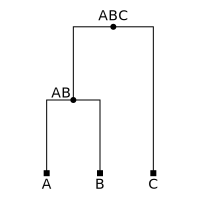

In [12]:
import tskit

tables = tskit.TableCollection(1)
for _ in range(3):
    tables.nodes.add_row(flags=tskit.NODE_IS_SAMPLE)
AB = tables.nodes.add_row(time=10)
ABC = tables.nodes.add_row(time=20)
tables.edges.add_row(0, 1, AB, 0)
tables.edges.add_row(0, 1, AB, 1)
tables.edges.add_row(0, 1, ABC, 2)
tables.edges.add_row(0, 1, ABC, AB)
tables.sort()

tree = tables.tree_sequence().first()
SVG(tree.draw_svg(node_labels={0:"A", 1:"B", 2:"C", 3:"AB", 4:"ABC"}))

We can describe this population topology as follows:

In [13]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.add_population(name="C", initial_size=100)
demography.add_population(name="AB", initial_size=100)
demography.add_population(name="ABC", initial_size=100)
demography.add_population_split(time=10, derived=["A", "B"], ancestral="AB")
demography.add_population_split(time=20, derived=["AB", "C"], ancestral="ABC")
demography

Demography(populations=[Population(initial_size=100, growth_rate=0, name='A', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=100, growth_rate=0, name='B', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=100, growth_rate=0, name='C', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=100, growth_rate=0, name='AB', description='', extra_metadata={}, default_sampling_time=10, initially_active=False, id=3), Population(initial_size=100, growth_rate=0, name='ABC', description='', extra_metadata={}, default_sampling_time=20, initially_active=False, id=4)], events=[PopulationSplit(time=10, derived=['A', 'B'], ancestral='AB'), PopulationSplit(time=20, derived=['AB', 'C'], ancestral='ABC')], migration_matrix=array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]))

:::{note}
Note that the
{ref}`default_sampling_time<sec_demography_populations_default_sampling_time>`
value for the ancestral populations is set to the time of the split event.
:::

The {ref}`debug output<sec_demography_debugging_tools>` for this demography
shows how the various populations become
{ref}`active and inactive<sec_demography_populations_life_cycle>`
over time:

In [14]:
demography.debug()

:::{seealso}
See the population tree {ref}`example<sec_demography_examples_population_tree>`
for a Human out-of-Africa model from the literature.
:::

It is also possible to have less tree-like population topologies, in which
several populations successively merge into one "trunk" population. For
example, here we define three populations, where ``B`` and ``C`` merge
into ``A`` 10 and 20 generations ago, respectively:

In [15]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100, initially_active=True)
demography.add_population(name="B", initial_size=100)
demography.add_population(name="C", initial_size=100)
demography.add_population_split(time=10, derived=["B"], ancestral="A")
demography.add_population_split(time=20, derived=["C"], ancestral="A")
demography.debug()

We can see that the ``B`` and ``C`` populations successively become
{ref}`inactive<sec_demography_populations_life_cycle>` as lineages
move into ``A``.

:::{important}
For trunk populations like ``A`` here we **must** set the ``initially_active``
flag if we want to draw samples from it at the present day.
:::

:::{seealso}
See the {ref}`trunk population example<sec_demography_examples_trunk_population>`
of this style of model from the literature.
:::


(sec_demography_events_admixture)=

#### Admixture

The {meth}`.Demography.add_admixture` method is used to declare
that a derived population is admixed from a set of ancestral populations.
In the following example we create a demography with 4 populations:
``A``, ``B`` and ``ADMIX`` are contemporary populations, and
``ANC`` is an ancestral root population. We add an admixture event
in which ``ADMIX`` is derived from ``A`` and ``B`` 10 generations ago,
and ``A`` and ``B`` then merge into ``ANC``
20 generations ago. The {ref}`debug output<sec_demography_debugging_tools>`
can help us understand what this means:

In [16]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.add_population(name="ADMIX", initial_size=100)
demography.add_population(name="ANC", initial_size=100)
demography.add_admixture(
    time=10, derived="ADMIX", ancestral=["A", "B"], proportions=[0.25, 0.75])
demography.add_population_split(time=20, derived=["A", "B"], ancestral="ANC")
demography.debug()

In the first epoch (from 0 to 10 generations ago) we have three active
populations: ``A``, ``B`` and ``ADMIX``. Then the admixture event
happens: {ref}`backwards in time<sec_demography_direction_of_time>`
we take all the lineages that are in ``ADMIX``, and for each one
we move it to ``A`` with probability 1/4 and to ``B`` with probability
3/4. In the next epoch (10 to 20 generations ago), we just have
populations ``A`` and ``B`` active because the derived ``ADMIX``
population is now inactive.

What does this mean forwards in time? In this case, rather than thinking
about sampled lineages moving from population to population we must think
about whole populations and individuals migrating.
So forwards in time, 10 generations ago
the ``ADMIX`` population suddenly appeared and it contained
100 individuals (note the initial size): 25 of these individuals were
migrants from ``A`` and the other 75 were migrants from ``B``.

:::{note}
The ``ANC`` population in this model isn't important, it's there
to ensure that it's possible for lineages to coalesce and
we don't get an {ref}`sec_ancestry_errors_infinite_waiting_time`.
:::

:::{seealso}
See the {ref}`American Admixture example<sec_demography_examples_admixture>`
below.
:::

(sec_demography_events_mass_migration)=

#### Pulse (mass) migration

:::{important}
We do not recommend using mass migration events unless it is
really necessary; most of the time, the desired effect can
be achieved using {ref}`sec_demography_events_population_split`
and {ref}`sec_demography_events_admixture` events. If you are
{ref}`msprime 0.x<sec_legacy_0x>` user who is accustomed to
working with mass migrations or updating legacy code, please
consider "migrating" to using these new, more specific, events.
:::

The {meth}`.Demography.add_mass_migration` method is used to
move a proportion of the lineages currently
in one population (the ``source``) to another (the ``dest``).

:::{warning}
There are two things it's vitally important to realise about mass migrations:

1. Like {ref}`continuous migration <sec_demography_migration>` the source
   and destination populations are from the perspective of the coalescent
   process, that is {ref}`backwards in time<sec_demography_direction_of_time>`.
   So, if a lineage is moved from
   `source` population ``A`` to `dest` population ``B`` by msprime, this
   corresponds to an individual moving **from** ``B`` **to** ``A``,
   forwards in time. (Yes, this is
   {ref}`confusing <sec_demography_migration>`!)

2. Mass migration events **do not** alter the migration rates between
   populations. So, even if all lineages are moved out of a
   particular population (i.e., if ``proportion=1``) that population
   may still have lineages migrating into it after the event. This
   can easily lead to errors when modelling population splits using
   {class}`.MassMigration` events. This error was present in the
   documentation for an older version of msprime, which lead to an
   incorrect version of an example demographic model being used
   in a number of publications. See
   [this paper](http://dx.doi.org/10.1016/j.ajhg.2020.08.017) for
   more details.
:::

The effect of mass migration events are summarised in the
{class}`.DemographyDebugger` output:

In [17]:
demography = msprime.Demography.island_model([100, 100], migration_rate=0.1)
demography.add_mass_migration(time=10, source=0, dest=1, proportion=0.5)
demography.debug()

(sec_demography_events_instantaneous_bottleneck)=

#### Instantaneous bottleneck

A common approach to modelling the effect of demographic history on genealogies
is to assume that effective population size ({math}`N_e`) changes in discrete steps
which define a series of epochs.
In this setting of piece-wise constant
{math}`N_e`, capturing a population bottleneck requires three epochs: {math}`N_e` is
reduced by some fraction {math}`b` at the start of the bottleneck,
{math}`T_{start}`, and
recovers to its initial value at time {math}`T_{end}` (Marth et al 2004).
If bottlenecks are short both on the timescale of coalescence and mutations, one
may expect little information about the duration of a bottleneck
{math}`(T_{end}-T_{start})` in sequence data.
Thus a simpler, alternative model is to assume that
bottlenecks are instantaneous
({math}`T_{end}-T_{start} \rightarrow 0`) and generate
a sudden burst of coalescence events in the genealogy.

The strength of the bottleneck {math}`B` can be thought of as an (imaginary)
time period during which coalescence events are collapsed, i.e. there is no
growth in genealogical branches during {math}`B` and the probability
that a single pair
of lineages entering the bottleneck coalesce during the bottleneck is
{math}`1-e^{-B}`.

In the following example we create a population of size 100,
and then 25 generations ago create a bottleneck equivalent to
200 generations of the coalescent using the
{meth}`~.Demography.add_instantaneous_bottleneck`
method:

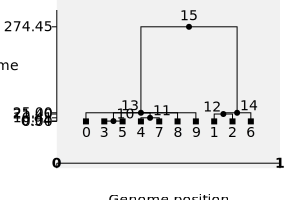

In [18]:
demography = msprime.Demography()
demography.add_population(initial_size=100)
demography.add_instantaneous_bottleneck(time=25, strength=200, population=0)

ts = msprime.sim_ancestry(5, demography=demography, random_seed=1234)
SVG(ts.draw_svg(y_axis=True, size=(300, 200)))

We can see that there is a strong burst of coalscence 25 generations ago.

:::{important}
Note that there is no possibility of recombination, migration or any other
events occuring during the bottleneck: it is strictly *instantaneous*
and can only result in coalscences within the trees.
:::

:::{seealso}
See [Bunnefeld et al. (2015)](https://doi.org/10.1534/genetics.115.179861)
and [Galtier et al. (2000)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1461106/)
for more details on this model of population bottlenecks.
:::


(sec_demography_events_simple_bottleneck)=

#### Simple bottleneck

In a {meth}`simple bottleneck<.Demography.add_simple_bottleneck>`
each lineage in a given population has a specified
probability of coalescing into a single ancestral lineage and a given
time. For example, here we create a bottleneck in which lineages
have a probability of 0.8 of coalescing at time 1:

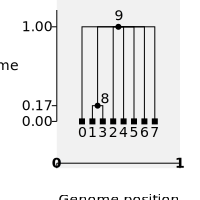

In [19]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=10)
demography.add_simple_bottleneck(time=1, population="A", proportion=0.8)

ts = msprime.sim_ancestry(4, demography=demography, random_seed=243)
SVG(ts.draw_svg(y_axis=True))

We can see that at time 1 we had 7 extant lineages, and all of these
happened to coalesce, leading to a large polytomy at the root.

:::{note}
The {meth}`.Demography.add_simple_bottleneck` method can be useful
for creating trees with particular properties, but it is not
based on any particular theoretical model and is unlikely to be
useful in modelling real populations.
:::

(sec_demography_demography_objects)=

## Demography objects

{class}`.Demography` objects provide a number of convenient ways of
accessing individual population data. Consider the following three
population example:

In [20]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=1)
demography.add_population(name="B", initial_size=2)
demography.add_population(name="C", initial_size=3)
demography

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,A,,1.0,0,0,{}
1,B,,2.0,0,0,{}
2,C,,3.0,0,0,{}


Demography objects are essentially a mapping from population identifiers
to the corresponding population objects, and behave like
a {class}`python:dict` with some extra methods. The additional
feature provided by the {class}`.Demography` class is that populations
can be found either by their integer ID their string names
(see the {ref}`sec_demography_populations_identifiers` section for more
details):

In [21]:
print(demography["B"])
print(demography[1])

Population(initial_size=2, growth_rate=0, name='B', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1)
Population(initial_size=2, growth_rate=0, name='B', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1)


Note that the ``keys`` for a Demography are the names:

In [22]:
list(demography.keys())

['A', 'B', 'C']

The values for population objects can be updated in-place. For example,
suppose we wanted to change the {ref}`sec_demography_populations_growth_rate`
for ``A`` to 0.001:

In [23]:
demography["A"].growth_rate = 0.001
demography

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,A,,1.0,0.001,0,{}
1,B,,2.0,0,0,{}
2,C,,3.0,0,0,{}


We can also loop over all populations using the standard dict protocols.
For example, if we wanted to multiply all population sizes by 100 we
could do:

In [24]:
for pop in demography.values():
    pop.initial_size *= 100
demography

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,A,,100.0,0.001,0,{}
1,B,,200.0,0,0,{}
2,C,,300.0,0,0,{}


(sec_demography_debugging_tools)=

## Debugging tools

Creating demographic models is a difficult and
[error prone](http://dx.doi.org/10.1016/j.ajhg.2020.08.017) process
and we need all the help we can get to avoid making mistakes.
Msprime provides some basic debugging utilities to help understand
and inspect the contents of {class}`.Demography` objects, as well
as understand how the model parameters change over time.

### Demography objects

When working in a Jupyter notebook environment it is very easy to
get a summary of the state of a Demography object: using Jupyter
magic, we write the variable at the end of a cell and it gets
summarised automatically:

In [25]:
# Define a demography
demography = msprime.Demography.island_model([100, 100], migration_rate=0.1)
# Ask Jupyter to print out a summary of it.
demography

Demography(populations=[Population(initial_size=100.0, growth_rate=0.0, name='pop_0', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=100.0, growth_rate=0.0, name='pop_1', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1)], events=[], migration_matrix=array([[0. , 0.1],
       [0.1, 0. ]]))

If you prefer to work in a terminal or other non-notebook environment
the same information can be accessed by converting the demography object
to a string, e.g., by calling ``print``:

In [26]:
print(demography)

Demography
╟  Populations
║  ┌────────────────────────────────────────────────────────────────────────────────────────────────┐
║  │ id │name   │description  │initial_size  │ growth_rate │  default_sampling_time│extra_metadata  │
║  ├────────────────────────────────────────────────────────────────────────────────────────────────┤
║  │ 0  │pop_0  │             │100.0         │      0      │                      0│{}              │
║  │ 1  │pop_1  │             │100.0         │      0      │                      0│{}              │
║  └────────────────────────────────────────────────────────────────────────────────────────────────┘
╟  Migration Matrix
║  ┌───────────────────────┐
║  │       │ pop_0 │ pop_1 │
║  ├───────────────────────┤
║  │  pop_0│   0   │  0.1  │
║  │  pop_1│  0.1  │   0   │
║  └───────────────────────┘
╟  Events
║  ┌───────────────────────────────────┐
║  │  time│type  │parameters  │effect  │
║  ├───────────────────────────────────┤
║  └───────────────────────────────

:::{note}
This may not render correctly in all browsers because of the lack of
support for fixed width fonts.
:::


### DemographyDebugger

The {class}`.DemographyDebugger` is a very useful tool for understanding
how a model changes over time. For example, let's consider a simple
population tree:

In [27]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=10_000)
demography.add_population(name="B", initial_size=5_000)
demography.add_population(name="C", initial_size=1_000)
demography.add_population_split(time=1000, derived=["A", "B"], ancestral="C")
demography.debug()

Here we define a {class}`.Demography` object and then get a visual
summary of the evolution of the model over time by calling
the {meth}`.Demography.debug` method (which returns a
{class}`.DemographyDebugger` instance).

The debugger splits time up in to simulation "epochs" during which all the
parameters are the same, and no events happen (as everywhere in msprime,
we work {ref}`backwards in time<sec_demography_direction_of_time>`). In
each epoch we give the state of the population parameters and migration
rates for all {ref}`active<sec_demography_populations_life_cycle>`
populations. We also show the events that signal the end of the epoch,
which create the next epoch.

Again, the same information is available for non-notebook users by
converting the debugger object to string:

In [28]:
print(demography.debug())

DemographyDebugger
╠══════════════════════════════════╗
║ Epoch[0]: [0, 1e+03) generations ║
╠══════════════════════════════════╝
╟    Populations (total=3 active=2)
║    ┌───────────────────────────────────────────────┐
║    │   │     start│       end│growth_rate  │ A │ B │
║    ├───────────────────────────────────────────────┤
║    │  A│   10000.0│   10000.0│ 0           │ 0 │ 0 │
║    │  B│    5000.0│    5000.0│ 0           │ 0 │ 0 │
║    └───────────────────────────────────────────────┘
╟    Events @ generation 1e+03
║    ┌──────────────────────────────────────────────────────────────────────────────┐
║    │  time│type        │parameters       │effect                                  │
║    ├──────────────────────────────────────────────────────────────────────────────┤
║    │  1000│Population  │derived=[A, B],  │Moves all lineages from derived         │
║    │      │Split       │ancestral=C      │populations 'A' and 'B' to the          │
║    │      │            │                 

:::{seealso}
The {class}`.DemographyDebugger` has a number of methods to
perform calculations based on a given demography. See the
{ref}`sec_demography_numerical` section for details and examples.
:::

(sec_demography_examples)=

## Example models

In this section we show how to build demographic models by working
through some example models from the literature.

(sec_demography_examples_population_tree)=

### Population tree

The first example we examine is the
[Gutenkunst et al.](http://dx.doi.org/10.1371/journal.pgen.1000695)
out-of-Africa model, in which the history of three present-day populations
is modelled by a tree of ancestral populations.

:::{important}
If you want to use this precise model in your analyses
we strongly recommend using {ref}`stdpopsim <stdpopsim:sec_introduction>`,
which provides a community maintained {ref}`catalog <stdpopsim:sec_catalog>`
of species information and demographic models for simulation. The
model given here is equivalent to the
{ref}`HomSap/OutOfAfrica_3G09 <stdpopsim:sec_catalog_homsap_models_outofafrica_3g09>`
model.
:::

First we declare some variables and compute some quantities that will
come in useful:

In [29]:
import math

# Times are provided in years, so we convert into generations.
generation_time = 25
T_OOA = 21.2e3 / generation_time
T_AMH = 140e3 / generation_time
T_ANC = 220e3 / generation_time
# We need to work out the starting population sizes based on
# the growth rates provided for these two populations
r_CEU = 0.004
r_CHB = 0.0055
N_CEU = 1000 / math.exp(-r_CEU * T_OOA)
N_CHB = 510 / math.exp(-r_CHB * T_OOA)
N_AFR = 12300

The time and other variables are declared here
following the [DRY](https://en.wikipedia.org/wiki/Don't_repeat_yourself)
principle: when we have to use the same numerical value more than
once it's a very good idea to use a variable to avoid errors. The
time conversions are needed because time in msprime is always measured
in generations, and the paper reported times in units of years.
The size computations are required because the paper reported
the European and Asian population sizes at the time they split
from the Out-of-Africa population, but we need the present-day
sizes.

Once we have computed these quantities we can declare the
{class}`.Demography` object representing the model we are
building and add some {ref}`sec_demography_populations`:

In [30]:
demography = msprime.Demography()
demography.add_population(
    name="YRI",
    description="Yoruba in Ibadan, Nigeria",
    initial_size=N_AFR,
)
demography.add_population(
    name="CEU",
    description=(
        "Utah Residents (CEPH) with Northern and Western European Ancestry"
    ),
    initial_size=N_CEU,
    growth_rate=r_CEU,
)
demography.add_population(
    name="CHB",
    description="Han Chinese in Beijing, China",
    initial_size=N_CHB,
    growth_rate=r_CHB,
)
demography.add_population(
    name="OOA",
    description="Bottleneck out-of-Africa population",
    initial_size=2100,
)
demography.add_population(
    name="AMH", description="Anatomically modern humans", initial_size=N_AFR
)
demography.add_population(
    name="ANC",
    description="Ancestral equilibrium population",
    initial_size=7300,
)
demography

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,YRI,"Yoruba in Ibadan, Nigeria",12300.0,0,0,{}
1,CEU,Utah Residents (CEPH) with Northern and Western European Ancestry,29725.3,0.004,0,{}
2,CHB,"Han Chinese in Beijing, China",54090.3,0.0055,0,{}
3,OOA,Bottleneck out-of-Africa population,2100.0,0,0,{}
4,AMH,Anatomically modern humans,12300.0,0,0,{}
5,ANC,Ancestral equilibrium population,7300.0,0,0,{}


Here we create a new {class}`.Demography` object and add six populations
using the {meth}`.Demography.add_population` method. The first three
populations represent present-day populations and the others ancestral
populations. For convenience, we define the
{ref}`sec_demography_populations_initial_size` of the ancestral populations
here, but technically those populations won't be
{ref}`active <sec_demography_populations_life_cycle>` until later in the
simulation (i.e., further back in time). To check that we have correctly
set up the starting states of the populations, we can look at the
HTML representation using Jupyter magic.

This sets up our populations, but there is no {ref}`sec_demography_migration`
between any of them, as we can see in the output migration matrix.
We can add migration to the model using the
{meth}`.Demography.set_symmetric_migration_rate` method (we can also
set asymmetric migration rates using {meth}`.Demography.set_migration_rate`,
but beware of the {ref}`confusion <sec_demography_migration>` around the
meaning of ``source`` and ``dest``).

In [31]:
# Set the migration rates between extant populations
demography.set_symmetric_migration_rate(["CEU", "CHB"], 9.6e-5)
demography.set_symmetric_migration_rate(["YRI", "CHB"], 1.9e-5)
demography.set_symmetric_migration_rate(["YRI", "CEU"], 3e-5)
demography

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,YRI,"Yoruba in Ibadan, Nigeria",12300.0,0,0,{}
1,CEU,Utah Residents (CEPH) with Northern and Western European Ancestry,29725.3,0.004,0,{}
2,CHB,"Han Chinese in Beijing, China",54090.3,0.0055,0,{}
3,OOA,Bottleneck out-of-Africa population,2100.0,0,0,{}
4,AMH,Anatomically modern humans,12300.0,0,0,{}
5,ANC,Ancestral equilibrium population,7300.0,0,0,{}
,YRI,CEU,CHB,OOA,AMH,ANC
YRI,0,3e-05,1.9e-05,0,0,0
CEU,3e-05,0,9.6e-05,0,0,0
CHB,1.9e-05,9.6e-05,0,0,0,0


Now we can see that the migration matrix shows the
appropriate rates between the extant populations.

:::{tip}
If you hover your mouse over an entry in the migration matrix
it will tell which populations are involved, and how the rate
can be interpreted.
:::

The model still does not have any sense of how the modern
and ancient populations relate to each other, or how
parameters change over time. To do this, we need to declare
some {ref}`sec_demography_events`:

In [32]:
demography.add_population_split(time=T_OOA, derived=["CEU", "CHB"], ancestral="OOA")
demography.add_symmetric_migration_rate_change(
    time=T_OOA, populations=["YRI", "OOA"], rate=25e-5
)
demography.add_population_split(time=T_AMH, derived=["YRI", "OOA"], ancestral="AMH")
demography.add_population_split(time=T_ANC, derived=["AMH"], ancestral="ANC")
demography

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,YRI,"Yoruba in Ibadan, Nigeria",12300.0,0,0,{}
1,CEU,Utah Residents (CEPH) with Northern and Western European Ancestry,29725.3,0.004,0,{}
2,CHB,"Han Chinese in Beijing, China",54090.3,0.0055,0,{}
3,OOA,Bottleneck out-of-Africa population,2100.0,0,8.5e+02,{}
4,AMH,Anatomically modern humans,12300.0,0,5.6e+03,{}
5,ANC,Ancestral equilibrium population,7300.0,0,8.8e+03,{}
,YRI,CEU,CHB,OOA,AMH,ANC
YRI,0,3e-05,1.9e-05,0,0,0
CEU,3e-05,0,9.6e-05,0,0,0
CHB,1.9e-05,9.6e-05,0,0,0,0


The first event we added was a {ref}`sec_demography_events_population_split`
using the {meth}`.Demography.add_population_split` method. This has
three effects:

1. At the time of the split, all lineages currently in the
``CEU`` and ``CHB`` populations are moved into ancestral
``OOA`` population (remember, this is
{ref}`backwards in time<sec_demography_direction_of_time>`).

2. It marks the ``OOA`` population as
{ref}`inactive <sec_demography_populations_life_cycle>`
"before"  the event, and sets its
{ref}`sampling time<sec_demography_populations_default_sampling_time>`
to the time of the population split (as can be seen in the Populations table
above).

3. It marks the ``CEU`` and ``CHB`` populations as
{ref}`previously active <sec_demography_populations_life_cycle>`
"after" the event. Any subsequent attempts to move lineages into these
populations will result in an error.

:::{tip}
The **effect** column in the events output summarises the effect of
each event.
:::

The next event is a {ref}`sec_demography_events_migration_rate_change`
using the {meth}`.Demography.add_symmetric_migration_rate_change` method,
that also happens at the Out-of-Africa split time. This sets the migration
rate between the ``OOA`` and ``YRI`` populations.

:::{note}
Any number of events can occur at the same time in msprime, and they are
guaranteed to be executed in the order that they are specified.
:::

The remaining events are then both population splits: 5600 generations
ago, the ``OOA`` and ``YRI`` split from the ``AMH`` population,
and finally 8800 generation ago the ``AMH`` population "split" from
the ``ANC`` population. This last population split may seem unnecessary,
since we could have achieved the same effect by a population
{ref}`size change<sec_demography_events_population_parameters_change>`,
but from an interpretation perspective it is much better to explicitly
model distinct phases as separate populations.

In [33]:
# Make sure we don't insert any errors in this version of the model.
# Once we have an equivalent version in stdpopsim we can update here
# to compare against that instead and remove the Demography._ooa_model()

demography.assert_equal(msprime.Demography._ooa_model())

We can now see the model as a set of populations, their initial state
and migration rates and a set of events. To help understand how this
model evolves over time the {class}`.DemographyDebugger` is extremely
useful. To get a debugger instance for a given demography use the
{meth}`.Demography.debug()` method. This will then display the
state of the demography as a set of "epochs", where we see the
state of the populations and the migration matrix during different
time periods:

:::{note}
Only populations that are **active** during a particular epoch
are displayed in the debugger output.
:::

In [34]:
demography.debug()

(sec_demography_examples_admixture)=

### Admixture

Many models of populations over time cannot be described as a simple
tree. In this example we implement the American Admixture model
from [Browning et al. 2011](https://doi.org/10.1371/journal.pgen.1007385).

:::{important}
If you want to use this precise model in your analyses
we strongly recommend using the {ref}`stdpopsim <stdpopsim:sec_introduction>`
{ref}`HomSap/AmericanAdmixture_4B11 <stdpopsim:sec_catalog_homsap_models_americanadmixture_4b11>`
model.
:::

We start again by assigning some values that we use repeatedly
to variables, declaring some populations, and setting up the
initial migration rates between the extant populations:

In [35]:
T_OOA = 920

demography = msprime.Demography()
demography.add_population(name="AFR", description="African", initial_size=14474)
demography.add_population(
    name="EUR",
    description="European",
    initial_size=34039,
    growth_rate=0.0038,
)
demography.add_population(
    name="EAS",
    description="East Asian",
    initial_size=45852,
    growth_rate=0.0048,
)
demography.add_population(
    name="ADMIX",
    description="Admixed America",
    initial_size=54664,
    growth_rate=0.05,
)
demography.add_population(
    name="OOA",
    description="Bottleneck out-of-Africa",
    initial_size=1861,
)
demography.add_population(
    name="AMH", description="Anatomically modern humans", initial_size=14474
)
demography.add_population(
    name="ANC",
    description="Ancestral equilibrium",
    initial_size=7310,
)
demography.set_symmetric_migration_rate(["AFR", "EUR"], 2.5e-5)
demography.set_symmetric_migration_rate(["AFR", "EAS"], 0.78e-5)
demography.set_symmetric_migration_rate(["EUR", "EAS"], 3.11e-5)

demography

Demography(populations=[Population(initial_size=14474, growth_rate=0, name='AFR', description='African', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=34039, growth_rate=0.0038, name='EUR', description='European', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=45852, growth_rate=0.0048, name='EAS', description='East Asian', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=54664, growth_rate=0.05, name='ADMIX', description='Admixed America', extra_metadata={}, default_sampling_time=None, initially_active=None, id=3), Population(initial_size=1861, growth_rate=0, name='OOA', description='Bottleneck out-of-Africa', extra_metadata={}, default_sampling_time=None, initially_active=None, id=4), Population(initial_size=14474, growth_rate=0, name='AMH', description='Anatomically modern humans', extra_metadata={}, default_sampling_time=None, initially_active=None, id=5), Population(initial_size=7310, growth_rate=0, name='ANC', description='Ancestral equilibrium', extra_metadata={}, default_sampling_time=None, initially_active=None, id=6)], events=[], migration_matrix=array([[0.00e+00, 2.50e-05, 7.80e-06, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00],
       [2.50e-05, 0.00e+00, 3.11e-05, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00],
       [7.80e-06, 3.11e-05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00]]))

Here we set up seven {ref}`populations<sec_demography_populations>`,
their initial states and the migration rates between them. The
next thing we do is add an {ref}`admixture<sec_demography_events_admixture>`
event 12 generations in the past:

In [36]:
demography.add_admixture(
    12,
    derived="ADMIX",
    ancestral=["AFR", "EUR", "EAS"],
    proportions=[1 / 6, 2 / 6, 3 / 6],
);

During a simulation, in an admixture event all of the lineages
present in the derived population move to one of the ancestral
populations with the appropriate probability. Forwards in time,
this corresponds to the initial state of the admixed population
being composed of these fractions of individuals from the
ancestral populations.

We can then add population split events, similar to the
{ref}`out of Africa model<sec_demography_examples_population_tree>`.
The {class}`.DemographyDebugger` output then shows how the
populations change over time:

In [37]:
demography.add_population_split(T_OOA, derived=["EUR", "EAS"], ancestral="OOA")
demography.add_symmetric_migration_rate_change(
    time=T_OOA, populations=["AFR", "OOA"], rate=15e-5
)
demography.add_population_split(2040, derived=["OOA", "AFR"], ancestral="AMH")
demography.add_population_split(5920, derived=["AMH"], ancestral="ANC")
demography.debug()

In [38]:
# Make sure we don't insert any errors in this version of the model.
# Once we have an equivalent version in stdpopsim we can update here
# to compare against that instead and remove the local model

demography.assert_equal(msprime.Demography._american_admixture_model())

(sec_demography_examples_trunk_population)=

### Trunk population models

For many empirical models we want to sequentially merge derived populations
into a "trunk" population. We illustrate this with a slightly different
version of the {ref}`example<sec_demography_examples_population_tree>` above,
this time defining only
four populations, as in this illustration of the model using
the [demography package](https://github.com/apragsdale/demography>)
(see also [Figure 2B](http://dx.doi.org/10.1371/journal.pgen.1000695.g002)
of the Gutenkunst et. al paper):

```{image} _static/Gutenkunst_OOA_diagram.svg
:width: 500px
:align: center
:alt: Schematic of Gutenkunst et al. (2009) out-of-Africa model.
```
:::{warning}
The version of this model in this documentation from 31 May 2016 to 29 May 2020
(on the stable branch) was **incorrect**. Specifically, it mistakenly
allowed for migration to continue beyond the merger of the African and
Eurasian bottleneck populations. This has now been fixed, but if you had
copied this model from the tutorial for your own analyses, you should
update your model code or use the implementation that has been verified in
{ref}`stdpopsim project <stdpopsim:sec_introduction>`. See
[here](https://github.com/jeromekelleher/msprime-model-errors) for more
details on the faulty model and its likely effects on downstream analyses.
:::

We proceed as before, calculating some quantities that we need
for the model, and creating a {class}`.Demography`:

In [39]:
# Times are provided in years, so we convert into generations.
generation_time = 25
T_OOA = 21.2e3 / generation_time
T_AMH = 140e3 / generation_time
T_ANC = 220e3 / generation_time
# We need to work out the starting population sizes based on
# the growth rates provided for these two populations
r_CEU = 0.004
r_CHB = 0.0055
N_CEU = 1000 / math.exp(-r_CEU * T_OOA)
N_CHB = 510 / math.exp(-r_CHB * T_OOA)

demography = msprime.Demography()
# This is the "trunk" population that we merge other populations into
demography.add_population(
    name="YRI",
    description="Africa",
    initial_size=12300,
    # NOTE: we have to set this flag if we have a population that's
    # ancestral in a population split *and* is contemporary population.
    initially_active=True,
);
demography.add_population(
    name="CEU",
    description="European",
    initial_size=N_CEU,
    growth_rate=r_CEU,
)
demography.add_population(
    name="CHB",
    description="East Asian",
    initial_size=N_CHB,
    growth_rate=r_CHB,
)
demography.add_population(
    name="OOA",
    description="Bottleneck out-of-Africa population",
    initial_size=2100,
)

# Set the migration rates between extant populations
demography.set_symmetric_migration_rate(["CEU", "CHB"], 9.6e-5)
demography.set_symmetric_migration_rate(["YRI", "CHB"], 1.9e-5)
demography.set_symmetric_migration_rate(["YRI", "CEU"], 3e-5)

demography.add_population_split(
    time=T_OOA, derived=["CEU", "CHB"], ancestral="OOA"
)
demography.add_symmetric_migration_rate_change(
    time=T_OOA, populations=["YRI", "OOA"], rate=25e-5
)
demography.add_population_split(
    time=T_AMH, derived=["OOA"], ancestral="YRI"
)
demography.add_population_parameters_change(
    time=T_ANC, population="YRI", initial_size=7300
);

The first population we add is ``YRI``, which represents both contemporary
African population as well as ancient populations (which are highly misleading
to label as ``YRI`` --- see the note below). This is the "trunk" population
that we merge other populations into over time, which we do via
{ref}`sec_demography_events_population_split` events. Because these events are
intended to conveniently model "population trees", we assume that the ancestral
population will be {ref}`inactive<sec_demography_populations_life_cycle>` before
the split (looking backwards). However, in this case, we will be merging the
``OOA`` population in to the ``YRI``, which we wish to also be
{ref}`active<sec_demography_populations_life_cycle>` at the start of the
simulation. To do this, we use the ``initially_active=True`` flag to
make sure that the ``YRI`` population is active, and can therefore
represent contemporary Africans as well as ancient populations.

We can see how the ``YRI`` population then remains active through
all epochs from the debug output:

In [40]:
demography.debug()

In [41]:
# Make sure we don't insert any errors in this version of the model.
# Once we have an equivalent version in stdpopsim we can update here
# to compare against that instead and remove the local model

demography.assert_equal(msprime.Demography._ooa_trunk_model())

:::{note}
We do not recommend using "trunk" populations in this way as it is
misleading to think of contemporary populations like the Yoruba being
in any way representative of the very ancient populations being
modelled in the oldest epochs.
:::

(sec_demography_importing)=

## Importing model definitions

(sec_demography_importing_demes)=

### Demes

```{eval-rst}
.. todo:: Details of how we import Demes models.
```


(sec_demography_importing_species_trees)=

### Species trees

Species trees hold information about the sequence and the times at which species
diverged from each other, which we model via a series of
{ref}`sec_demography_events_population_split`.
The {meth}`.Demography.from_species_tree` method parses a
species tree in [Newick format](https://en.wikipedia.org/wiki/Newick_format)
and returns a {class}`.Demography` object. These species trees do not contain
any information on the sizes of the relevant populations, however, and so these
must be specified separately using the ``initial_size`` argument
(see {ref}`sec_demography_populations_initial_size`).
When species trees are estimated with a program like
[StarBEAST](<https://academic.oup.com/mbe/article/34/8/2101/3738283>) they can
contain estimates on the population sizes of extant and ancestral species.
The {meth}`.Demography.from_starbeast` method parses species trees estimated
with StarBEAST and sets the population sizes accordingly.

:::{important}
When a species tree has branch lengths in units of years or millions of years
rather than generations (which is common), a generation time in years
must be specified.
:::

Species trees must be encoded in
[Newick](<https://en.wikipedia.org/wiki/Newick_format>) format, with named leaves and
branch lengths. Consider the following species tree of four primates, for example:

```
(((human:5.6,chimpanzee:5.6):3.0,gorilla:8.6):9.4,orangutan:18.0)
```

When visualized in software like
[FigTree](http://tree.bio.ed.ac.uk/software/figtree/), the tree
looks like this:

```{figure} _static/primates.svg
:width: 400px
:alt: A species tree with branch lengths.
```

The numbers written on branches indicate the lengths of these branches,
which in this case is expressed in millions of years. We can then
convert this species tree into a {class}`.Demography` using the
{meth}`.Demography.from_species_tree`:

In [42]:
import msprime

demography = msprime.Demography.from_species_tree(
    "(((human:5.6,chimpanzee:5.6):3.0,gorilla:8.6):9.4,orangutan:18.0)",
    initial_size=10_000,
    time_units="myr",
    generation_time=28)
demography.debug()

Because the species tree does not contain complete information about the
demographic model, we must provide some extra information. The
``initial_size`` parameter lets us specify the size of each of the
populations; here we give all the populations a fixed size of 10,000
(there is much more flexibility here, however). Because the branch
lengths in the species tree are given in millions of years, we also
need provide a ``time_units`` parameter and a ``generation_time``.

The epoch boundaries 200000, 307142.9, and 642857.1 correspond to the species
divergence times 5.6, 8.6, and 18.0 after converting the branch length units
of the species tree from millions of years to generations with the specified
generation time of 28 years.


Running the simulation is then straightforward:

In [43]:
ts = msprime.sim_ancestry(
    {"human": 2, "orangutan": 2}, demography=demography, random_seed=2)
ts

Note that the names of the populations are recorded in the population
metadata:

In [44]:
for population in ts.populations():
    print(population.metadata)

{'description': '', 'name': 'human'}
{'description': '', 'name': 'chimpanzee'}
{'description': '', 'name': 'gorilla'}
{'description': '', 'name': 'orangutan'}
{'description': '', 'name': 'pop_4'}
{'description': '', 'name': 'pop_5'}
{'description': '', 'name': 'pop_6'}


(sec_demography_numerical)=

## Numerical utilities

### Population sizes over time

When working with exponential growth models it is useful to be able to compute
the sizes of the populations at given times. The
{meth}`.DemographyDebugger.population_size_trajectory` gives a straightforward
way of doing this. For example, here we create two exponentially growing populations
and show how their sizes change over time:

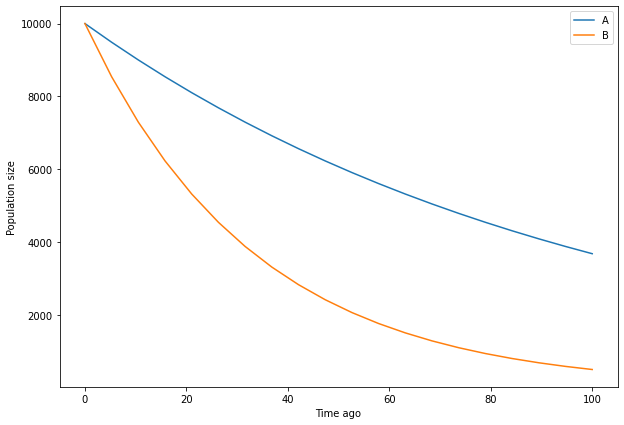

In [45]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=10000, growth_rate=0.01)
demography.add_population(name="B", initial_size=10000, growth_rate=0.03)

debug = demography.debug()

t = np.linspace(0, 100, num=20)
S = debug.population_size_trajectory(t)
plt.plot(t, S, label=["A", "B"])
plt.xlabel("Time ago")
plt.ylabel("Population size")
plt.legend();

### Possible locations of lineages

When debugging a demographic model it can be helpful to track the possible
location of ancestral lineages over time, as determined by the model
structure and the initial composition of the sample. For example,
here we create a simple model involving a
{ref}`population split<sec_demography_events_population_split>`, and then
use the {meth}`~.DemographyDebugger.possible_lineage_locations` method:

In [46]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.add_population(name="C", initial_size=100)
demography.add_population_split(time=500, derived=["A", "B"], ancestral="C")

debug = demography.debug()
debug.possible_lineage_locations()

{(0.0, 500.0): array([ True,  True, False]),
 (500.0, inf): array([False, False,  True])}

The method returns a mapping of time intervals to numpy boolean arrays.
The keys are ``(start, end]`` intervals during which the possible location
of samples are the same, and the values are arrays telling us whether
a given population can have lineages present during this epoch or not.
By default,
{meth}`~.DemographyDebugger.possible_lineage_locations` assumes that we
draw samples from all populations that have a
{ref}`default sampling time<sec_demography_populations_default_sampling_time>`
of zero, and so for the initial period between time 0 and 500 we
can have samples in population "A" and "B", but not in "C". The next time
slice, from 500 generations ago onwards, we can only
have lineages in population "C" (because after the population split all
lineages will be in the ancestral population).

We can also specify that we are interested in sampling from specific
populations at particular times. Suppose we take samples from "A" at
time 0 and from "B" at time 20:

In [47]:
debug.possible_lineage_locations([
    msprime.SampleSet(1, population="A", time=0),
    msprime.SampleSet(1, population="B", time=20),
])

{(0.0, 20): array([ True, False, False]),
 (20, 500.0): array([ True,  True, False]),
 (500.0, inf): array([False, False,  True])}

Now, we can have lineages in "A" from 0 to 20 generations ago, but not
in "B".

:::{note}
The number of samples we supply per population isn't important
(once it's greater than 0).
:::

The effects of migration are also taken into account by this method.
For example, consider a different model in which we have two initially
isolated populations, with migration between then introduced 50
generations ago:

In [48]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.add_symmetric_migration_rate_change(
    time=50, populations=["A", "B"], rate=0.01)

debug = demography.debug()
debug.possible_lineage_locations(["A"])

{(0.0, 50.0): array([ True, False]), (50.0, inf): array([ True,  True])}

Because we only sampled lineages in "A", we cannot have
any lineages in "B" until after the migration between the
the two after 50 generations ago.

### Lineage probabilities

The {meth}`~.DemographyDebugger.lineage_probabilities` method computes
the probability that a lineage sampled at a given time in a each population
is present in any other population at a set of times in the past.
Consider a simple
{ref}`population split<sec_demography_events_population_split>` model:

In [49]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.add_population(name="C", initial_size=100)
demography.add_population_split(time=500, derived=["A", "B"], ancestral="C")

debug = demography.debug()
debug.lineage_probabilities([250, 750])

array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]])

Here we ask to compute the matrix of lineage probabilities 250 and
750 generations ago, before and after the population split. Before the
split, any lineages sampled in a population can only still be in
that population so the diagonal of the matrix is 1. After the
split, all lineages must be in population "C", and so the
corresponding column is 1.

Migration is taken into account in these calculations.
If we add some migration between "A" and "B",
we can see how lineages equilibrate between the two:

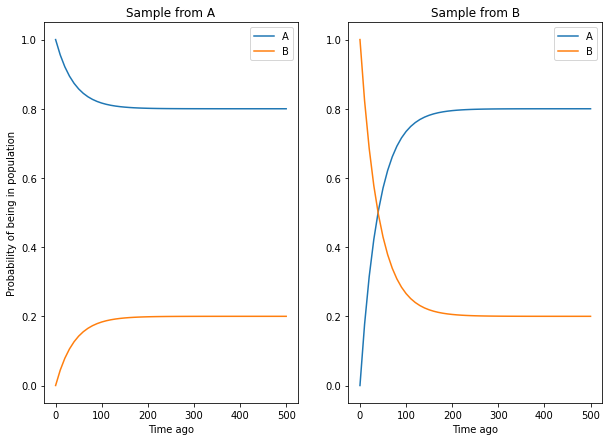

In [50]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.set_migration_rate(source="A", dest="B", rate=0.005)
demography.set_migration_rate(source="B", dest="A", rate=0.02)

debug = demography.debug()
T = np.linspace(0, 500, 51)
X = debug.lineage_probabilities(T)

for j, pop in enumerate(demography.populations):
    plt.subplot(1, 2, j + 1)
    for k, dest_pop in enumerate(demography.populations):
        plt.plot(T, X[:, j, k], label=dest_pop.name)
    plt.legend()
    plt.xlabel("Time ago")
    plt.title(f"Sample from {pop.name}")
    if j == 0:
        plt.ylabel("Probability of being in population");

Since migration is asymmetric, lineages are more likely
to be found in population "A".
We've set the migration rate for *lineages*
to be higher from "B" to "A", so lineages tend to spend more time in "A".
Since the two populations have the same size,
this corresponds (in forwards time) to a higher flux of migrants from "A" to "B",
as would happen if mean fecundity in "A" is higher than in "B".

We can also use this to see how lineages spread out over discrete
space in a 1D {meth}`~.Demography.stepping_stone_model`:

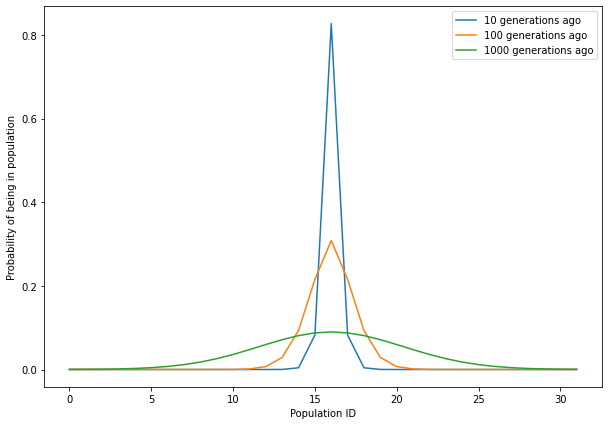

In [51]:
N = 32
demography = msprime.Demography().stepping_stone_model(
    initial_size=[100] * N, migration_rate=0.01)

debug = demography.debug()
T = [10, 100, 1000]
X = debug.lineage_probabilities(T)

for t, x in zip(T, X):
    plt.plot(x[N // 2], label=f"{t} generations ago")
plt.legend()
plt.xlabel("Population ID");
plt.ylabel("Probability of being in population");

Here we create a 32 population stepping stone model, and
compute the matrix of lineage probabilities at 10, 100
and 1000 generations ago. We then plot the probability
of lineages sampled in the middle population
being present in the linearly-connected populations.
As we can see, 10 generations ago, the probability
of lineages being present falls off quickly with
distance, but as we go further back into the past
the possible location of lineages becomes more evenly
distributed in space.

(sec_demography_numerical_coalescence)=

### Coalescence rates and mean times

Lineage probabilities tell us where lineages might possibly be,
which uses only information about migration rates and population splits.
Using information about population sizes,
we can also compute the *coalescence rates*,
using {meth}`.DemographyDebugger.coalescence_rate_trajectory`.
For instance, here are the three pairwise coalescence rate trajectories
in the two-population model with migration above:

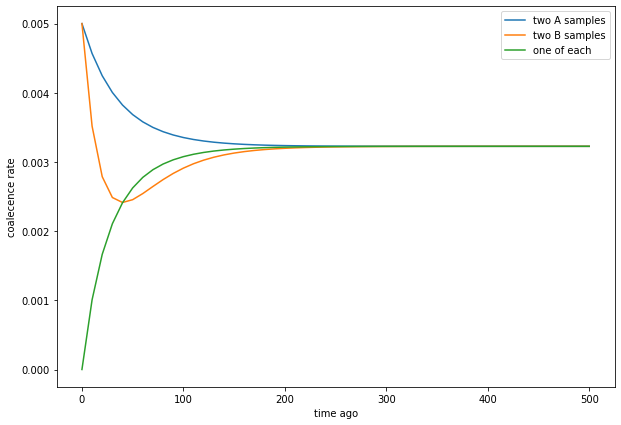

In [52]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.set_migration_rate(source="A", dest="B", rate=0.005)
demography.set_migration_rate(source="B", dest="A", rate=0.02)

debug = demography.debug()
T = np.linspace(0, 500, 51)
RAA, _ = debug.coalescence_rate_trajectory(T, {"A": 2})
RBB, _ = debug.coalescence_rate_trajectory(T, {"B": 2})
RAB, _ = debug.coalescence_rate_trajectory(T, {"A": 1, "B": 1})

plt.plot(T, RAA, label="two A samples")
plt.plot(T, RBB, label="two B samples")
plt.plot(T, RAB, label="one of each")
plt.legend()
plt.xlabel("time ago")
plt.ylabel("coalecence rate");

The coalescence rate of lineages sampled from different populations begins at zero,
and increases as the chance of them migrating to the same population increases.
Interestingly, the coalescence rate of two lineages in population "B"
is nonmonotonic, due to the asymmetric migration rates.

Many properties of genomes (e.g., mean genetic diversity) are determined
by mean coalescence times, which we can compute with
{meth}`.DemographyDebugger.mean_coalescence_time`.
For instance, we might want to know how the three pairwise mean coalescence times
change as we make the migration rate less asymmetric:

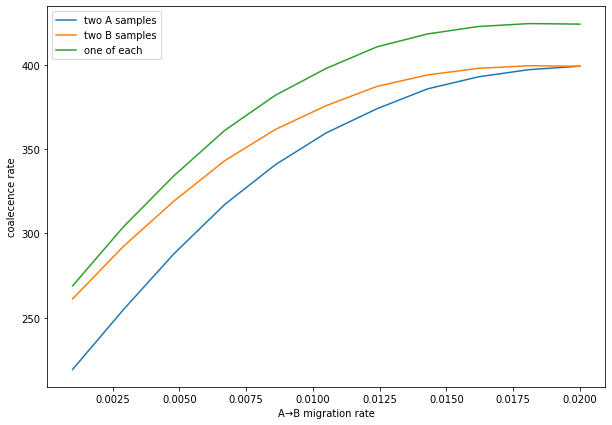

In [53]:
def get_mean_coaltimes(m):
    demography.set_migration_rate(source="A", dest="B", rate=m)
    debug = demography.debug()
    TAA = debug.mean_coalescence_time({"A": 2})
    TBB = debug.mean_coalescence_time({"B": 2})
    TAB = debug.mean_coalescence_time({"A": 1, "B": 1})
    return [TAA, TBB, TAB]

M = np.linspace(0.001, 0.02, 11)
T = np.zeros((len(M), 3))
for j, m in enumerate(M):
    T[j, :] = get_mean_coaltimes(m)

plt.plot(M, T[:,0], label="two A samples")
plt.plot(M, T[:,1], label="two B samples")
plt.plot(M, T[:,2], label="one of each")
plt.legend()
plt.xlabel("A→B migration rate")
plt.ylabel("coalecence rate");

From this, we can see that genetic diversity increases as the migration rate increases,
that divergence between the populations is always greater than diversity within either,
and that diversity within "B" goes from a level close to that found between populations
to that within "A", as the "A→B" migration rate approaches the "B→A" rate.


(sec_demography_numerical_trajectories)=

### Inverse instantaneous coalescence rates

Coalescence rates are analogous to effective population sizes,
in that if {math}`r(t)` is the coalescence rate at time {math}`t` ago
between two lineages from a population in *any* population model,
then a single population of changing size,
with {math}`2 N(t) = 1/r(t)` genomes at time {math}`t` ago,
has exactly the same distribution of coalescence times.
(The factor of two assumes the organisms are diploid,
and this assumes a continuous-time model.)
One reason this is helpful is because we often fit simplified demographic models
to more complex reality,
and we might expect models that fit a single population-size-over-time
to infer something closer to the inverse coalescence rate.
For more discussion, see
[Chikhi et al., 2018](https://doi.org/10.1038/s41437-017-0005-6) and
[Adrion et al., 2020](https://doi.org/10.7554/eLife.54967).

For instance, let's take the Gutenkunst et al 2009 "Out of Africa" model
we used above in the {ref}`sec_demography_examples_population_tree` section,
and compare inverse coalescence rates to actual population sizes.
To follow along, first you should define ``demography`` as in the section above.
Next we make a grid of times, ``T``,  spanning the last 10,000 generations,
and calculate coalescence rates at these times:

In [54]:
demography = msprime.Demography._ooa_model()

In [55]:
# first define Gutenkunst et al model as above
debug = demography.debug()

T = np.concatenate([
    np.linspace(0, 1000, 2001),
    np.linspace(1000, 1e4, 401)[1:]
])

R = np.zeros((len(T), 3))
R[:,0], _ = debug.coalescence_rate_trajectory(T, {"YRI": 2})
R[:,1], _ = debug.coalescence_rate_trajectory(T, {"CEU": 2})
R[:,2], _ = debug.coalescence_rate_trajectory(T, {"CHB": 2})

The time values look a bit weird because when at first we set them to have
equal spacing across the whole time period
we got a warning about possible numerical inaccuracy
(and inaccurate trajectories).
This is because {meth}`.DemographyDebugger.coalescence_rate_trajectory`
uses the provided time steps to calculate a discrete approximation
to the trajectory, and for this to be a good approximation
we need to take small time steps when the population is changing in size rapidly.
In this model, the rapid growth occurs recently, so we need a finer grid
of time steps in the last 1,000 generations.

Next we compute the "census sizes", and plot these
along with the inverse instantaneous coalescence rates.
Since {meth}`.DemographyDebugger.population_size_trajectory`
gives us population sizes for each of the six populations
(three modern and three ancient),
we need to do some work to copy the right population sizes over
(e.g., prior to the most recent split we should use sizes for the
shared "OOA" population for both the non-African populations).

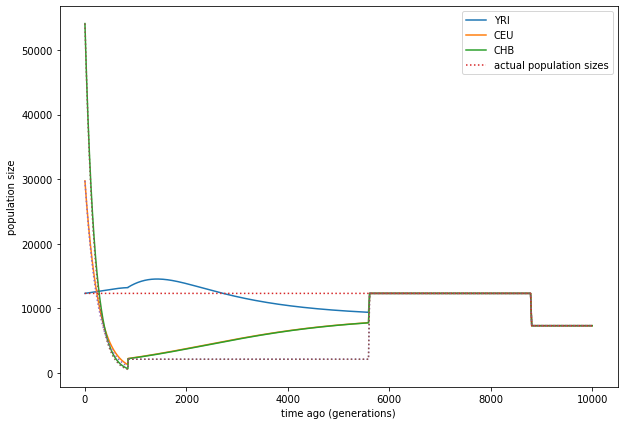

In [56]:
N = debug.population_size_trajectory(T)
# CEU-CHB merge
which_T = (T >= debug.epoch_start_time[1])
for j in (1, 2):
    N[which_T, j] = N[which_T, 3]
# OOA-Afr merge
which_T = (T >= debug.epoch_start_time[2])
for j in (0, 1, 2):
    N[which_T, j] = N[which_T, 4]
which_T = (T >= debug.epoch_start_time[3])
for j in (0, 1, 2):
    N[which_T, j] = N[which_T, 5]

plt.plot(T, 1/(2*R), label=[demography.populations[j].name for j in range(3)])
plt.plot(T, N[:,:3], ":", label=["actual population sizes", None, None])
plt.legend()
plt.xlabel("time ago (generations)")
plt.ylabel("population size");

We can see that the inverse instantaneous coalescence rates
do not respond instantly to population size changes,
when there's more than one population with migration between them.
(If we had a *single* population, the inverse coalescence rates
would exactly match the population size.)
So, if the true history matched this model
and we inferred the population-size-through-time using only "CEU" samples,
we might expect the inferred history to have a gradual increase back towards the out-of-Africa bottleneck,
instead of the actual sudden change at the bottleneck,
which is due to subsequent population structure.